In [1]:
import os
import cv2
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_transforms = {
'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomPosterize(bits=2),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),

            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomPosterize(bits=2),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])    
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_dir = '../dataset'
train_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'train'),
    transform=data_transforms['train']
)

val_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'val'),
    transform=data_transforms['val']
)

In [3]:
class_names = train_data.classes
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

dataloaders = {  
    'train': Data.DataLoader(
        dataset=train_data,
        batch_size=32,
        shuffle=True,
    ),

    'val': Data.DataLoader(
        dataset=val_data,
        batch_size=1,
        shuffle=True,
    ),    
}

In [4]:
vgg = torchvision.models.vgg16(pretrained=True) 
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True) 
        self.conv = nn.Sequential(
            self.vgg.features, 
            self.vgg.avgpool 
        )
        self.fc = nn.Linear(512, 5)

    def forward(self,x):    
        x = self.conv(x)
        x = x.view(-1, 512, 7*7).mean(2)
        x = self.fc(x)
        return x 

def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    
    best_accuracy = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        step_loss = 0.0
        epoch_accuracy = 0.0
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            step_loss = 0.0
            step_corrects = 0
            
            for step, (images, labels) in enumerate(dataloaders[phase]):      
               
                images, labels = images.to(device), labels.to(device)
                outputs = model(images) 
                preds = torch.max(outputs, 1)[1]
                loss = loss_fn(outputs, labels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                step_loss += loss.item() * images.size(0)
                step_corrects += torch.sum(preds == labels.data)
            
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = step_loss / dataset_sizes[phase]
            epoch_accuracy = step_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_accuracy)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_accuracy)

            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
        
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))

    x = np.arange(num_epochs)
    plt.subplot(221)
    plt.plot(x, train_loss, c='red', label='train loss')
    plt.plot(x, val_loss, c='blue', label='val loss')
    plt.legend(loc='best')

    plt.subplot(222)
    plt.plot(x, train_acc, c='red', label='train acc')
    plt.plot(x, val_acc, c='blue', label='val acc')
    plt.legend(loc='best')

    plt.show()    
    return model

In [5]:
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
        
def visualize_model(model, num_images=6):
    was_training = model.training # if true, the model is in training mode otherwise in evaluate mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for step, (images, labels) in enumerate(dataloaders['val']): 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        
        for i in range(images.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[i]]))
            imshow(images.cpu().data[i])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)

In [6]:
model = VGG()
model = model.to(device)

trainable_parameters = []
for name, p in model.named_parameters():
    if "fc" in name:
        trainable_parameters.append(p)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(trainable_parameters, lr=0.001, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/10
train Loss: 1.4863 Accuracy: 0.4726
val Loss: 1.3158 Accuracy: 0.7273
Epoch 2/10
train Loss: 1.1209 Accuracy: 0.8204
val Loss: 1.0270 Accuracy: 0.8485
Epoch 3/10
train Loss: 0.8675 Accuracy: 0.9576
val Loss: 0.8078 Accuracy: 0.9596
Epoch 4/10
train Loss: 0.7029 Accuracy: 0.9663
val Loss: 0.6772 Accuracy: 0.9848
Epoch 5/10
train Loss: 0.6010 Accuracy: 0.9763
val Loss: 0.5720 Accuracy: 0.9798
Epoch 6/10
train Loss: 0.5157 Accuracy: 0.9875
val Loss: 0.5132 Accuracy: 0.9949
Epoch 7/10
train Loss: 0.4509 Accuracy: 0.9850
val Loss: 0.4598 Accuracy: 0.9848
Epoch 8/10
train Loss: 0.4285 Accuracy: 0.9875
val Loss: 0.4505 Accuracy: 0.9949
Epoch 9/10
train Loss: 0.4251 Accuracy: 0.9875
val Loss: 0.4534 Accuracy: 0.9747
Epoch 10/10
train Loss: 0.4223 Accuracy: 0.9825
val Loss: 0.4416 Accuracy: 0.9848
Best Validation Accuracy: 0.994949


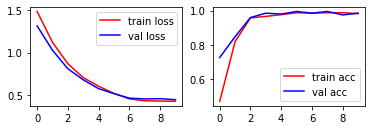

In [7]:
model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

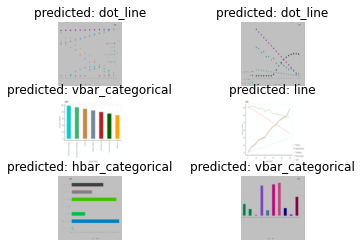

In [8]:
visualize_model(model)

In [9]:
model = model.to('cpu')

params = list(model.fc.parameters())
weight = np.squeeze(params[0].data.numpy())

image, label = next(iter(dataloaders['val']))

model.eval()
scores = model(image)
probs = F.softmax(scores, dim=1).data.squeeze()
probs, idx = probs.sort(0, True)

print('ground truth: ', class_names[label])
print('prediction: ', class_names[idx[0].numpy()])

ground truth:  dot_line
prediction:  dot_line


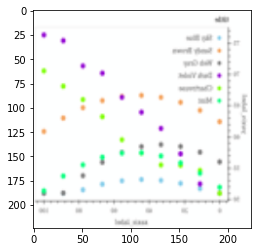

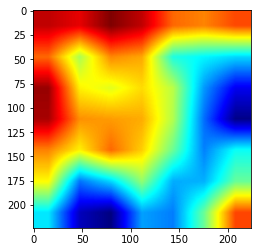

In [10]:
def return_CAM(feature_conv, weight, class_idx):
    size_upsample = (224, 224)

    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

feature_maps = model.conv(image)

CAMs = return_CAM(feature_maps.detach().numpy(), weight, [idx.numpy()[0]])
heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET)

image = image.reshape((3, 224, 224)).numpy().transpose((1, 2, 0)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = image * std + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.show()
plt.imshow(heatmap)
plt.show()